In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN, GRU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy.optimize import minimize
from math import radians, sin, cos, acos, asin, sqrt, atan2, degrees
from scipy.spatial import distance

In [ ]:
pd.set_option('display.max_columns', None)  # Set the maximum number of columns to display to None
pd.set_option('display.max_rows', None)  # Set the maximum number of rows to display to None

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/'My Drive'/YVW/new_job2.xlsx .

In [ ]:
# Read the data from an Excel file
sensor_data = pd.read_excel('new_job2.xlsx')

# Print Sensor data
sensor_data.head()

,year,month,day,hour,minute,WMS0117,WMS0103.A3_F,WMS0103.A3_P,WMS0104.A3_F,WMS0104.A3_P,WMS0116.A3_F,WMS0116.A3_P,WBS628.A3_F,WBS628.A3_P1,WBS628.A3_P2,DMA_Formula,job_id,Latitude,Longitude,Priority,label
0,2023,4,1,0,0,91.393029,13.095120,95.394749,10.582292,57.750720,2.331083,56.177239,11.0625,96.328125,52.81250,14.945995,NaN,NaN,NaN,NaN,0
1,2023,4,1,0,5,90.903227,13.046548,95.394749,11.197309,57.750720,2.331083,56.177239,11.3125,96.890625,52.75000,15.262439,NaN,NaN,NaN,NaN,0
2,2023,4,1,0,10,90.323462,12.389993,94.926688,10.691623,57.451958,2.035655,56.276827,11.1250,96.140625,52.53125,13.992271,NaN,NaN,NaN,NaN,0
3,2023,4,1,0,15,90.463405,11.849278,95.384790,10.127473,57.800514,2.057267,56.456084,11.1250,96.515625,52.81250,12.909018,NaN,NaN,NaN,NaN,0
4,2023,4,1,0,20,90.363446,12.919364,95.215491,10.293949,57.750720,3.145877,56.466043,11.0000,96.890625,52.59375,15.359190,NaN,NaN,NaN,NaN,0


In [ ]:
# Filter the dataset where label == 1
leakage_data = sensor_data[sensor_data['label'] == 1]

In [ ]:
leakage_data.head()

,year,month,day,hour,minute,WMS0117,WMS0103.A3_F,WMS0103.A3_P,WMS0104.A3_F,WMS0104.A3_P,WMS0116.A3_F,WMS0116.A3_P,WBS628.A3_F,WBS628.A3_P1,WBS628.A3_P2,DMA_Formula,job_id,Latitude,Longitude,Priority,label
732,2023,4,3,13,0,91.173118,19.074255,94.896812,13.213749,57.382247,4.245909,57.412123,12.9375,96.093750,52.0000,23.596413,8082462.0,-37.757291,145.12543,3.0,1
733,2023,4,3,13,5,91.852843,20.282167,94.896812,13.213749,57.382247,3.502653,57.412123,12.8125,95.953125,52.0000,24.186070,8082462.0,-37.757291,145.12543,3.0,1
734,2023,4,3,13,10,90.593353,21.090418,94.896812,13.589628,56.525795,3.983783,57.302577,13.0625,96.421875,52.0625,25.601329,8082462.0,-37.757291,145.12543,3.0,1
735,2023,4,3,13,15,90.993191,20.886726,95.374831,14.648073,57.043650,3.567081,57.163154,15.8125,95.906250,50.7500,23.289381,8082462.0,-37.757291,145.12543,3.0,1
736,2023,4,3,13,20,91.632932,19.812401,95.135821,16.497705,56.635341,3.742476,57.710885,12.2500,96.375000,52.1875,27.802583,8082462.0,-37.757291,145.12543,3.0,1


In [ ]:
# Sensor coordinates (latitude, longitude)
sensor_coords = {
    'WBS628': (-37.758, 145.118)
}
sensor_list = list(sensor_coords.keys())
sensor_list_d = ['D_' + sub for sub in sensor_list]
sensor_list_d

['D_WBS628']

In [ ]:
# calculate a Bearing between two coordinates
# https://mapscaping.com/how-to-calculate-bearing-between-two-coordinates/
def calculate_bearing(lat1, lon1, lat2, lon2):
  # Convert latitude and longitude to radians
  lat1 = math.radians(lat1)
  lon1 = math.radians(lon1)
  lat2 = math.radians(lat2)
  lon2 = math.radians(lon2)

  # Calculate the bearing
  bearing = math.atan2(
      math.sin(lon2 - lon1) * math.cos(lat2),
      math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(lon2 - lon1)
  )

  # Convert the bearing to degrees
  bearing = math.degrees(bearing)

  # Make sure the bearing is not larger than 360
  bearing = (bearing + 360) % 360

  return bearing

In [ ]:
# Calculating distance - Retrun haversine formula distance in km
# convert the coordinates from degrees to radians and use the sine and cosine functions
# along with the Earth’s mean radius (6371.01 km) to calculate the distance.
# https://blog.finxter.com/5-best-ways-to-find-the-distance-between-two-cities-in-python/
# https://www.themathdoctors.org/distances-on-earth-2-the-haversine-formula/
def calculate_distance(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    # Apply Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    # Radius of Earth in kilometers
    r = 6371
    dist = c * r
    return dist

# Retrun Euclidean distance
#def calculate_distance(lat1, lon1, lat2, lon2):
#    return np.sqrt((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2)

In [ ]:
# Calculate distances for each leakage location
distances = []
bearings = []
for index, row in leakage_data.iterrows():
    lat, lon = row['Latitude'], row['Longitude']
    row_distances = {
        sensor: calculate_distance(lat, lon, coords[0], coords[1])
        for sensor, coords in sensor_coords.items()
    }
    row_bearing = {
        sensor: calculate_bearing(lat, lon, coords[0], coords[1])
        for sensor, coords in sensor_coords.items()
    }
    distances.append(row_distances)
    bearings.append(row_bearing)

In [ ]:
# Convert distances to DataFrame
distances_df = pd.DataFrame(distances)
bearings_df = pd.DataFrame(bearings)


In [ ]:
print(distances_df.head())

     WBS628
0  0.657928
1  0.657928
2  0.657928
3  0.657928
4  0.657928


In [ ]:
print(bearings_df.head())

       WBS628
0  263.120301
1  263.120301
2  263.120301
3  263.120301
4  263.120301


In [ ]:
distances_df.rename(columns = {'WBS628':'D_WBS628'}, inplace = True)

In [ ]:
bearings_df.rename(columns = { 'WBS628':'B_WBS628'}, inplace = True)

In [ ]:
# Merge sensor data with distances
sensor_data_with_distances = sensor_data[sensor_data['label'] == 1].reset_index(drop=True)
sensor_data_with_distances = pd.concat([sensor_data_with_distances, distances_df], axis=1)
sensor_data_with_distances = pd.concat([sensor_data_with_distances, bearings_df], axis=1)
sensor_data_with_distances = pd.concat([sensor_data_with_distances], axis=1)


In [ ]:
sensor_data_with_distances.head()

,year,month,day,hour,minute,WMS0117,WMS0103.A3_F,WMS0103.A3_P,WMS0104.A3_F,WMS0104.A3_P,WMS0116.A3_F,WMS0116.A3_P,WBS628.A3_F,WBS628.A3_P1,WBS628.A3_P2,DMA_Formula,job_id,Latitude,Longitude,Priority,label,D_WBS628,B_WBS628
0,2023,4,3,13,0,91.173118,19.074255,94.896812,13.213749,57.382247,4.245909,57.412123,12.9375,96.093750,52.0000,23.596413,8082462.0,-37.757291,145.12543,3.0,1,0.657928,263.120301
1,2023,4,3,13,5,91.852843,20.282167,94.896812,13.213749,57.382247,3.502653,57.412123,12.8125,95.953125,52.0000,24.186070,8082462.0,-37.757291,145.12543,3.0,1,0.657928,263.120301
2,2023,4,3,13,10,90.593353,21.090418,94.896812,13.589628,56.525795,3.983783,57.302577,13.0625,96.421875,52.0625,25.601329,8082462.0,-37.757291,145.12543,3.0,1,0.657928,263.120301
3,2023,4,3,13,15,90.993191,20.886726,95.374831,14.648073,57.043650,3.567081,57.163154,15.8125,95.906250,50.7500,23.289381,8082462.0,-37.757291,145.12543,3.0,1,0.657928,263.120301
4,2023,4,3,13,20,91.632932,19.812401,95.135821,16.497705,56.635341,3.742476,57.710885,12.2500,96.375000,52.1875,27.802583,8082462.0,-37.757291,145.12543,3.0,1,0.657928,263.120301


In [ ]:
sensor_data_with_distances.dtypes

,0
year,int64
month,int64
day,int64
hour,int64
minute,int64
WMS0117,float64
WMS0103.A3_F,float64
WMS0103.A3_P,float64
WMS0104.A3_F,float64
WMS0104.A3_P,float64


In [ ]:
# The function takes the starting latitude and longitude, the distance in kilometers, and the bearing in degrees as input parameters.
# It then converts these values to radians and applies the Haversine formula to calculate the destination latitude and longitude.
#https://dnmtechs.com/calculating-latitude-and-longitude-using-distance-and-bearing-in-python-3/
def calculate_location(lat1, lon1, distance, bearing):
    R = 6371  # Radius of the Earth in kilometers

    # Convert latitude and longitude to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    bearing = math.radians(bearing)

    # Calculate the destination latitude and longitude
    lat2 = math.asin(math.sin(lat1) * math.cos(distance/R) + math.cos(lat1) * math.sin(distance/R) * math.cos(bearing))
    lon2 = lon1 + math.atan2(math.sin(bearing) * math.sin(distance/R) * math.cos(lat1), math.cos(distance/R) - math.sin(lat1) * math.sin(lat2))

    # Convert latitude and longitude back to degrees
    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)

    return lat2, lon2

In [ ]:
sensor_data_with_distances.head()

,year,month,day,hour,minute,WMS0117,WMS0103.A3_F,WMS0103.A3_P,WMS0104.A3_F,WMS0104.A3_P,WMS0116.A3_F,WMS0116.A3_P,WBS628.A3_F,WBS628.A3_P1,WBS628.A3_P2,DMA_Formula,job_id,Latitude,Longitude,Priority,label,D_WBS628,B_WBS628
0,2023,4,3,13,0,91.173118,19.074255,94.896812,13.213749,57.382247,4.245909,57.412123,12.9375,96.093750,52.0000,23.596413,8082462.0,-37.757291,145.12543,3.0,1,0.657928,263.120301
1,2023,4,3,13,5,91.852843,20.282167,94.896812,13.213749,57.382247,3.502653,57.412123,12.8125,95.953125,52.0000,24.186070,8082462.0,-37.757291,145.12543,3.0,1,0.657928,263.120301
2,2023,4,3,13,10,90.593353,21.090418,94.896812,13.589628,56.525795,3.983783,57.302577,13.0625,96.421875,52.0625,25.601329,8082462.0,-37.757291,145.12543,3.0,1,0.657928,263.120301
3,2023,4,3,13,15,90.993191,20.886726,95.374831,14.648073,57.043650,3.567081,57.163154,15.8125,95.906250,50.7500,23.289381,8082462.0,-37.757291,145.12543,3.0,1,0.657928,263.120301
4,2023,4,3,13,20,91.632932,19.812401,95.135821,16.497705,56.635341,3.742476,57.710885,12.2500,96.375000,52.1875,27.802583,8082462.0,-37.757291,145.12543,3.0,1,0.657928,263.120301


In [ ]:
exclude_columns = ['year', 'day', 'month','minute','hour','job_id','Latitude','Longitude','Priority','label','WMS0117','WMS0103.A3_F','WMS0103.A3_P','WMS0116.A3_F','WMS0116.A3_P','WMS0104.A3_F','WMS0104.A3_P','D_WBS628','B_WBS628']  # replace with actual column names
# Get the list of column names except for the ones to exclude
remaining_columns = sensor_data_with_distances.drop(columns=exclude_columns).columns.tolist()

# Add the remaining columns to the features array
features = remaining_columns
target = ['D_WBS628','B_WBS628']

In [ ]:
print(features)

['WBS628.A3_F', 'WBS628.A3_P1', 'WBS628.A3_P2', 'DMA_Formula']


In [ ]:
print(sensor_data_with_distances.dtypes)

year              int64
month             int64
day               int64
hour              int64
minute            int64
WMS0117         float64
WMS0103.A3_F    float64
WMS0103.A3_P    float64
WMS0104.A3_F    float64
WMS0104.A3_P    float64
WMS0116.A3_F    float64
WMS0116.A3_P    float64
WBS628.A3_F     float64
WBS628.A3_P1    float64
WBS628.A3_P2    float64
DMA_Formula     float64
job_id          float64
Latitude        float64
Longitude       float64
Priority        float64
label             int64
D_WBS628        float64
B_WBS628        float64
dtype: object


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
x_scaler = MinMaxScaler()

# Function to create sliding windows with actual leakage point coordinates
def create_sliding_window_with_coordinates(df, window_size=20, step_size=1):
    X, y, actual_coords, job_ids, priorities = [], [], [], [], []
    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window = df.iloc[start:end]
        feature_columns = features
        # normalized the feature_columns
        X.append(x_scaler.fit_transform(window[feature_columns].values))
        # Targets: distances to each sensor (last row in the window)
        y.append(window[target].values[-1])
        # Actual leakage point coordinates (from the last row in the window)
        actual_lat = window['Latitude'].values[-1]
        actual_lon = window['Longitude'].values[-1]
        actual_coords.append([actual_lat, actual_lon])
        # Append job_id and Priority for the last row in the window
        job_ids.append(window['job_id'].values[-1])
        priorities.append(window['Priority'].values[-1])
    return np.array(X), np.array(y), np.array(actual_coords), np.array(job_ids), np.array(priorities)

In [ ]:
# Prepare data using sliding window
window_size = 80
step_size = 1

# Create sliding windows
normalized_features, target, actual_coords, job_ids, priorities = create_sliding_window_with_coordinates(sensor_data_with_distances, window_size, step_size)

# Initialize the scaler
y_scaler = MinMaxScaler()


# normalized the target
normalized_target =  y_scaler.fit_transform(target)


In [ ]:
print(f"\nFeatures Shape: {normalized_features.shape}")
print(f"Target Shape: {normalized_target.shape}")
print(f"Actual Coordinates Shape: {actual_coords.shape}")
print(f"job_ids Shape: {job_ids.shape}")
print(f"priorities Shape: {priorities.shape}")


Features Shape: (39063, 80, 4)
Target Shape: (39063, 2)
Actual Coordinates Shape: (39063, 2)
job_ids Shape: (39063,)
priorities Shape: (39063,)


In [ ]:
# Train-test split for validation and testing

# Split the data into training and temporary sets (80% training, 20% temporary)
X_train, X_tmp, y_train, y_tmp, actual_train_coords, actual_tmp_coords, job_ids_train, job_ids_temp, priorities_train, priorities_temp = train_test_split(
    normalized_features, normalized_target, actual_coords,job_ids,priorities, test_size=0.2, random_state=0
)

# Further split the temporary set into validation and testing sets (50% each)
X_val, X_test, y_val, y_test, actual_val_coords, actual_test_coords, job_ids_val, job_ids_test, priorities_val, priorities_test = train_test_split(
    X_tmp, y_tmp, actual_tmp_coords, job_ids_temp, priorities_temp, test_size=0.5, random_state=0
)


In [ ]:
# Check data split sizes
print("Shape of Training Set: ", X_train.shape, y_train.shape, actual_train_coords.shape, job_ids_train.shape, priorities_train.shape)
print("Shape of Validation Set: ", X_val.shape, y_val.shape, actual_val_coords.shape,job_ids_val.shape, priorities_val.shape)
print("Shape of Testing Set: ", X_test.shape, y_test.shape, actual_test_coords.shape,job_ids_test.shape, priorities_test.shape)

Shape of Training Set:  (31250, 80, 4) (31250, 2) (31250, 2) (31250,) (31250,)
Shape of Validation Set:  (3906, 80, 4) (3906, 2) (3906, 2) (3906,) (3906,)
Shape of Testing Set:  (3907, 80, 4) (3907, 2) (3907, 2) (3907,) (3907,)


In [ ]:
# Initialize a sequential model
model = Sequential()

# RNN layers
model.add(SimpleRNN(70, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(SimpleRNN(48, activation='relu'))

# Dense layer and Dropout Layer
model.add(Dense(36, activation='relu'))
model.add(Dropout(0.1))

# Output layers for distance predictions
model.add(Dense(2))

# Print model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 80, 70)              │           5,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 48)                  │           5,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 36)                  │           1,764 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 36)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              74 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,800 (50.00 KB)

 Trainable params: 12,800 (50.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

#set the random seed for TensorFlow
np.random.seed(0)
tf.random.set_seed(0)

# Adding early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-9, restore_best_weights=True)

# Compile the model
#model.compile(optimizer=Adam(learning_rate=0.00001), loss='mse', metrics=['mae'])
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'] )

In [ ]:
# Train the model
# set shuffle=False to enforce shuffle the data with a set random seed
history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr],
                    shuffle=False
                   )

Epoch 1/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 44s 42ms/step - loss: 0.1138 - mae: 0.2583 - val_loss: 0.0529 - val_mae: 0.1674 - learning_rate: 1.0000e-04
Epoch 2/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - loss: 0.0572 - mae: 0.1772 - val_loss: 0.0517 - val_mae: 0.1641 - learning_rate: 1.0000e-04
Epoch 3/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 78s 40ms/step - loss: 0.0551 - mae: 0.1721 - val_loss: 0.0510 - val_mae: 0.1617 - learning_rate: 1.0000e-04
Epoch 4/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - loss: 0.0537 - mae: 0.1690 - val_loss: 0.0507 - val_mae: 0.1598 - learning_rate: 1.0000e-04
Epoch 5/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - loss: 0.0535 - mae: 0.1679 - val_loss: 0.0505 - val_mae: 0.1597 - learning_rate: 1.0000e-04
Epoch 6/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 77s 41ms/step - loss: 0.0528 - mae: 0.1664 - val_loss: 0.0506 - val_mae: 0.1601 - learning_rate: 1.0000e-04
Epoch 7/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - loss: 0.0521 - mae: 0.1651 - val_loss: 0.0506 - v

In [ ]:
# Save the entire model to a file
model.save('/content/drive/My Drive/YVW/kit_628_model.h5')

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# Replace the path with the actual path to your .h5 file
model_path = '/content/drive/My Drive/YVW/kit_628_model.h5'
model = load_model(model_path, custom_objects={'mse': MeanSquaredError()})

In [ ]:
import joblib
#save scaler
save_path = '/content/drive/MyDrive/YVW/kit_628_x_scaler.pkl'
# Save the scaler to a file in Google Drive
joblib.dump(x_scaler, save_path)
#save scaler
save_path = '/content/drive/MyDrive/YVW/kit_628_y_scaler.pkl'
# Save the scaler to a file in Google Drive
joblib.dump(y_scaler, save_path)

['/content/drive/MyDrive/YVW/kit_628_y_scaler.pkl']

In [ ]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test MAE: {mae}')


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0204 - mean_absolute_error: 0.1004
Test Loss: 0.020318644121289253
Test MAE: 0.09988979995250702


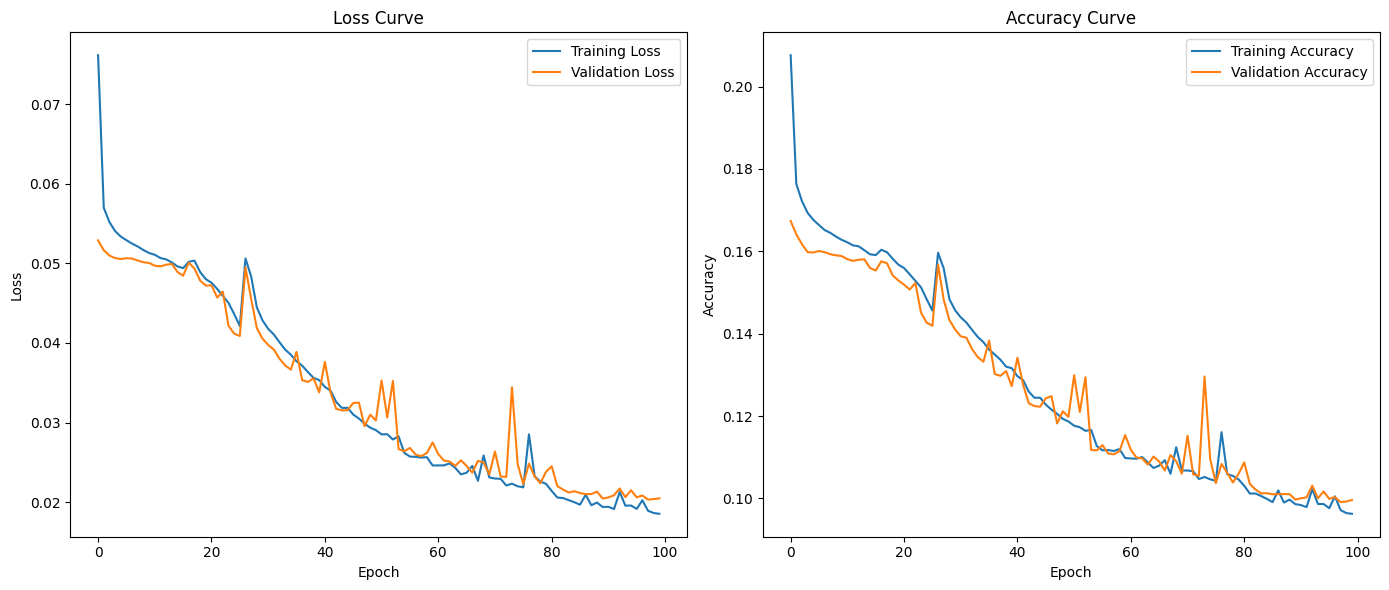

In [ ]:
# Extract loss and accuracy values from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['mae']
val_accuracy = history.history['val_mae']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot loss
ax1.plot(loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.set_title('Loss Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy
ax2.plot(accuracy, label='Training Accuracy')
ax2.plot(val_accuracy, label='Validation Accuracy')
ax2.set_title('Accuracy Curve')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Display plots
plt.tight_layout()
plt.show()

In [ ]:
predicted_result = model.predict(X_test)

123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [ ]:
from sklearn.metrics import mean_squared_error
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predicted_result))
print(f'Test RMSE: {rmse}')

Test RMSE: 0.14254346964114165


In [ ]:
sensor_list = ['WBS628']

In [ ]:
sensor_list_b = ['B_WBS628']

In [ ]:
# check the prediction performance
from sklearn.metrics import mean_squared_error

predicted_val_df = pd.DataFrame(y_scaler.inverse_transform(predicted_result), columns=[sensor_list + sensor_list_b])
actual_val_df = pd.DataFrame(y_scaler.inverse_transform(y_test), columns=[sensor_list + sensor_list_b])

for val in sensor_list:
    print(val+ " Distance Different (km): "+str(pd.DataFrame(actual_val_df[val]-predicted_val_df[val]).mean()))
    print(val+ " MSE (km): "+str(mean_squared_error(actual_val_df[val], predicted_val_df[val])))

for val in sensor_list:
    print(val+ " Degree Different (degree): "+str(pd.DataFrame(actual_val_df[val]-predicted_val_df[val]).mean()))
    print(val+ " MSE (degree): "+str(mean_squared_error(actual_val_df[val], predicted_val_df[val])))

WBS628 Distance Different (km): WBS628    0.042797
dtype: float64
WBS628 MSE (km): 0.10136946988664677
WBS628 Degree Different (degree): WBS628    0.042797
dtype: float64
WBS628 MSE (degree): 0.10136946988664677


In [ ]:
# check the prediction performance - actual data
actual_val_df.head(5)

,WBS628,B_WBS628
0,2.074625,256.885023
1,0.978616,248.162978
2,1.079454,236.959307
3,2.171614,297.272478
4,2.303233,258.542080


In [ ]:
# check the prediction performance - predict data
predicted_val_df.head(5)

,WBS628,B_WBS628
0,1.907604,267.958649
1,1.008093,265.742432
2,0.976767,280.704346
3,1.709814,269.819427
4,2.027584,271.068848


In [ ]:
def get_location(sensor_coords, predicted_result_val):

    i = len(sensor_coords)
    lat_sum = 0
    lon_sum = 0
    for sensor, (lat, lon) in sensor_coords.items():
      if sensor in predicted_result_val:
        distance = predicted_result_val[sensor]
        bearing = predicted_result_val["B_"+sensor]
        bearing = (bearing + 180) % 360
        lat2, lon2 = calculate_location(lat, lon, distance, bearing)
        lat_sum += lat2
        lon_sum += lon2
      else:
            print(f"Missing key for sensor: {sensor}")

    return [lat_sum/i, lon_sum/i]

In [ ]:
sensor_coords

{'WBS628': (-37.758, 145.118)}

In [ ]:
print(predicted_val_df.keys())


MultiIndex([(  'WBS628',),
            ('B_WBS628',)],
           )


In [ ]:
common_points = []
pred_range = len(predicted_result)
#pred_range = 1

for i, dist_array in enumerate(y_scaler.inverse_transform(predicted_result[0:pred_range])):
    predicted_result_val = dict(zip(sensor_list+sensor_list_b, dist_array))
    estimated_point = get_location(sensor_coords, predicted_result_val)
    common_points.append(estimated_point)

# convert estimated points list to dataframe
common_points = np.array(common_points)
estimated_leakage_df = pd.DataFrame(common_points, columns=['Estimated_Latitude', 'Estimated_Longitude'])
actual_leakage_df = pd.DataFrame(actual_test_coords[0:pred_range], columns=['Actual_Latitude', 'Actual_Longitude'])
job_ids_df = pd.DataFrame(job_ids_test[0:pred_range], columns=['Job_ID'])
priorities_df = pd.DataFrame(priorities_test[0:pred_range], columns=['Priority'])

# combine the estimated and actual leakage points
results_df = pd.concat([estimated_leakage_df, actual_leakage_df, job_ids_df, priorities_df], axis=1)

In [ ]:
# error between estimated and actual leakage points
results_df['Lat_Error'] = results_df['Estimated_Latitude'] - results_df['Actual_Latitude']
results_df['Lon_Error'] = results_df['Estimated_Longitude'] - results_df['Actual_Longitude']
# error in Euclidean distance
results_df['Total_Error_ED'] = np.sqrt(results_df['Lat_Error']**2 + results_df['Lon_Error']**2)
results_df['Job_ID'] = results_df['Job_ID'].astype(int)
print("Error Statistics:")
print(results_df[['Lat_Error', 'Lon_Error', 'Total_Error_ED']].mean())

results_df.head()

Error Statistics:
Lat_Error         0.000134
Lon_Error         0.001078
Total_Error_ED    0.005839
dtype: float64


,Estimated_Latitude,Estimated_Longitude,Actual_Latitude,Actual_Longitude,Job_ID,Priority,Lat_Error,Lon_Error,Total_Error_ED
0,-37.757387,145.139685,-37.753769,145.140984,8362874,3.0,-0.003618,-0.001298,0.003844
1,-37.757326,145.129435,-37.754727,145.128333,8249945,3.0,-0.002600,0.001102,0.002824
2,-37.759631,145.128918,-37.752707,145.128293,8234575,3.0,-0.006924,0.000625,0.006952
3,-37.757950,145.137449,-37.766951,145.139956,8325264,3.0,0.009001,-0.002507,0.009344
4,-37.758338,145.141060,-37.753888,145.143677,8169737,3.0,-0.004450,-0.002617,0.005162


In [ ]:
pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 67.2 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import contextily as cx
import geopandas as gpd
import pandas as pd

def plot_estimate_point(sensor_coords, results_df):
    # Convert the results_df DataFrame to a GeoDataFrame for both estimated and actual points
    results_est_gdf = gpd.GeoDataFrame(results_df, geometry=gpd.points_from_xy(results_df['Estimated_Longitude'], results_df['Estimated_Latitude']), crs='EPSG:4326').to_crs('EPSG:3857')
    results_act_gdf = gpd.GeoDataFrame(results_df, geometry=gpd.points_from_xy(results_df['Actual_Longitude'], results_df['Actual_Latitude']), crs='EPSG:4326').to_crs('EPSG:3857')

    # Convert the sensor_coords to a DataFrame and GeoDataFrame
    sensor_df = pd.DataFrame.from_dict(sensor_coords, orient='index', columns=['Latitude', 'Longitude'])
    sensor_gdf = gpd.GeoDataFrame(sensor_df, geometry=gpd.points_from_xy(sensor_df['Longitude'], sensor_df['Latitude']), crs='EPSG:4326').to_crs('EPSG:3857')

    # Plot the estimated and actual points
    plt.figure(figsize=(15, 10))
    ax = results_est_gdf.plot(figsize=(15, 10), color="blue", label='Estimated')
    results_act_gdf.plot(ax=ax, color="green", label='Actual')
    sensor_gdf.plot(ax=ax, color="red", label='Sensor')

    # Add lines between actual and estimated points
    for i, row in results_df.iterrows():
        ax.plot([results_act_gdf.geometry.x[i], results_est_gdf.geometry.x[i]],
                [results_act_gdf.geometry.y[i], results_est_gdf.geometry.y[i]],
                color='grey', linewidth=1, alpha=0.5)

    # Add basemap using Contextily
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()


<Figure size 1500x1000 with 0 Axes>

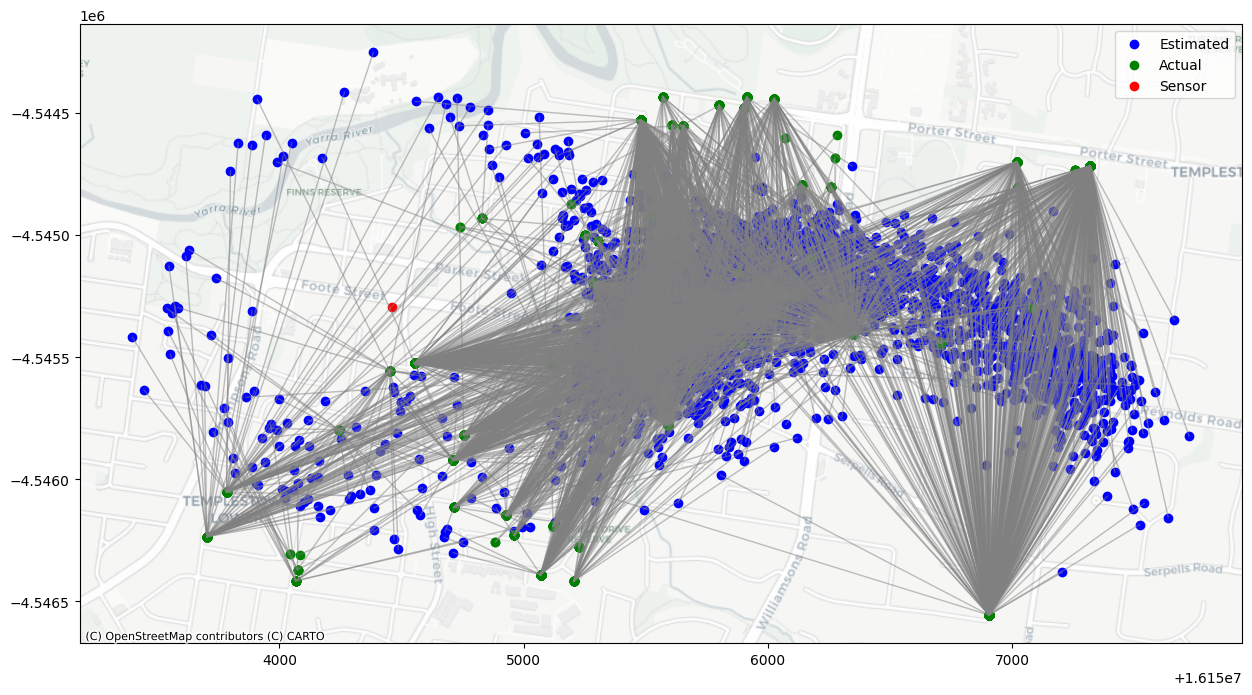

In [ ]:
# Example usage of the function:
plot_estimate_point(sensor_coords, results_df)

<Figure size 1500x1000 with 0 Axes>

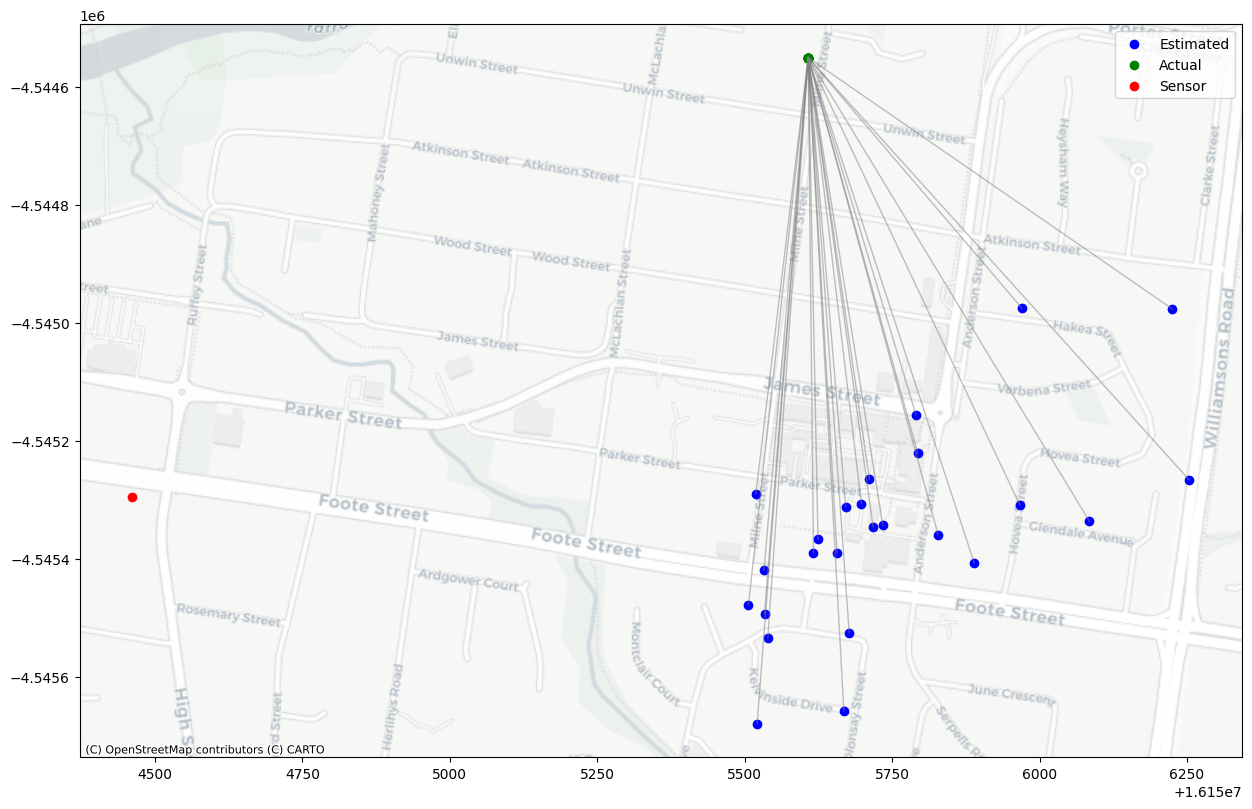

In [ ]:
# Individual Actual vs. All Estimate Lekage Points Plot
Act_Latitude_List = results_df.Actual_Latitude.unique()
plot_estimate_point(sensor_coords, results_df.loc[results_df['Actual_Latitude'] == Act_Latitude_List[2]])

In [ ]:
results_df.head()

,Estimated_Latitude,Estimated_Longitude,Actual_Latitude,Actual_Longitude,Job_ID,Priority,Lat_Error,Lon_Error,Total_Error_ED
0,-37.757387,145.139685,-37.753769,145.140984,8362874,3.0,-0.003618,-0.001298,0.003844
1,-37.757326,145.129435,-37.754727,145.128333,8249945,3.0,-0.002600,0.001102,0.002824
2,-37.759631,145.128918,-37.752707,145.128293,8234575,3.0,-0.006924,0.000625,0.006952
3,-37.757950,145.137449,-37.766951,145.139956,8325264,3.0,0.009001,-0.002507,0.009344
4,-37.758338,145.141060,-37.753888,145.143677,8169737,3.0,-0.004450,-0.002617,0.005162


In [ ]:
# Get the Estimated Leakage Location Mean Point
results_mean_df = results_df.groupby(['Actual_Latitude', 'Actual_Longitude'])[['Estimated_Latitude', 'Estimated_Longitude']].mean().reset_index()

# Display the results_mean_df
print(results_mean_df.head())


   Actual_Latitude  Actual_Longitude  Estimated_Latitude  Estimated_Longitude
0       -37.766951        145.139956          -37.759043           145.140264
1       -37.765970        145.124678          -37.759099           145.129604
2       -37.765960        145.114450          -37.760278           145.118957
3       -37.765779        145.123457          -37.758531           145.128473
4       -37.765637        145.114515          -37.763058           145.114926


<Figure size 1500x1000 with 0 Axes>

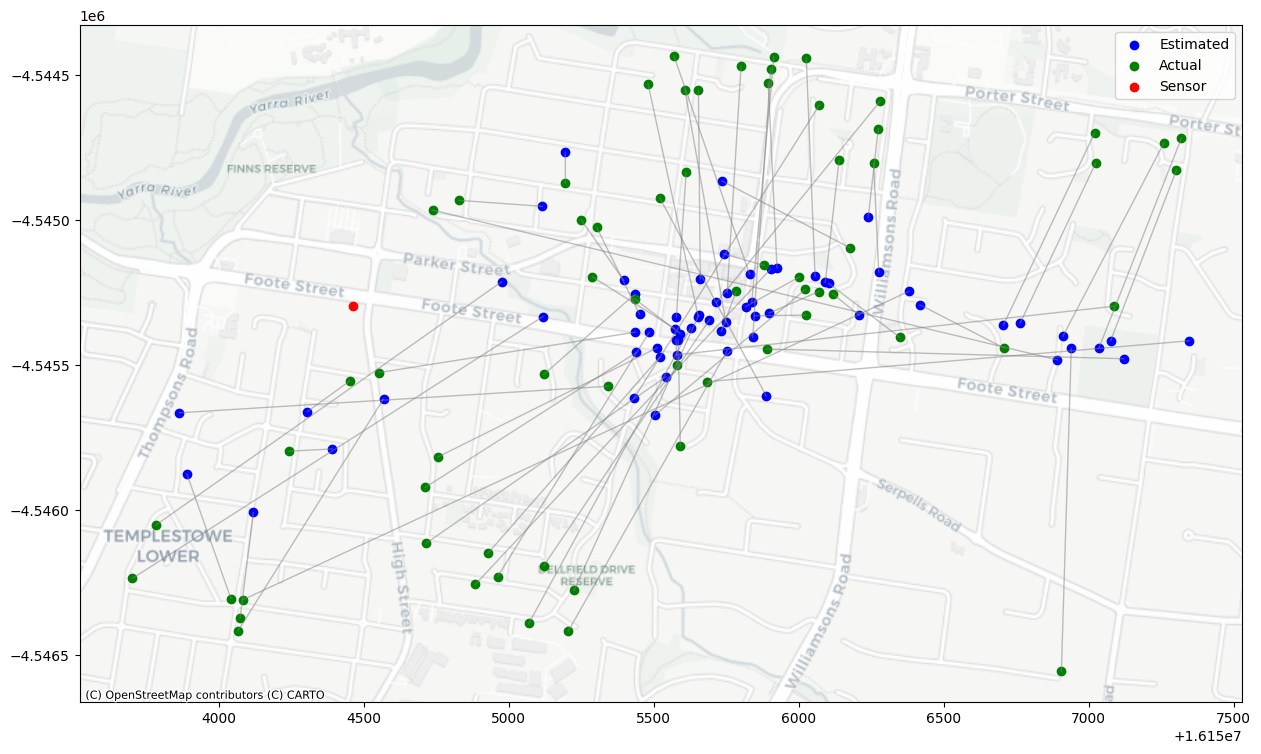

In [ ]:
# Actual vs. Mean of Estimate Lekage Points Plot
plot_estimate_point(sensor_coords, results_mean_df)

In [ ]:
# Get the Estimated Leakage Location Mean Point along with Job_ID and Priority
results_mean_df = results_df.groupby(['Job_ID', 'Priority', 'Actual_Latitude', 'Actual_Longitude'])[['Estimated_Latitude', 'Estimated_Longitude']].mean().reset_index()

# Display the results_mean_df
print(results_mean_df.head())


    Job_ID  Priority  Actual_Latitude  Actual_Longitude  Estimated_Latitude  \
0  8082462       3.0       -37.757291        145.125430          -37.758555   
1  8084696       3.0       -37.759454        145.128055          -37.758825   
2  8084826       1.0       -37.754677        145.143522          -37.758856   
3  8088170       2.0       -37.765970        145.124678          -37.759099   
4  8092648       3.0       -37.758228        145.132048          -37.758242   

   Estimated_Longitude  
0           145.127974  
1           145.128016  
2           145.141481  
3           145.129604  
4           145.130458  


In [ ]:
import matplotlib.pyplot as plt
import contextily as cx
import geopandas as gpd
import pandas as pd

def plot_estimate_point_names(sensor_coords, results_df):
    # Convert the results_df DataFrame to a GeoDataFrame for both estimated and actual points
    results_est_gdf = gpd.GeoDataFrame(results_df, geometry=gpd.points_from_xy(results_df['Estimated_Longitude'], results_df['Estimated_Latitude']), crs='EPSG:4326').to_crs('EPSG:3857')
    results_act_gdf = gpd.GeoDataFrame(results_df, geometry=gpd.points_from_xy(results_df['Actual_Longitude'], results_df['Actual_Latitude']), crs='EPSG:4326').to_crs('EPSG:3857')

    # Convert the sensor_coords to a DataFrame and GeoDataFrame
    sensor_df = pd.DataFrame.from_dict(sensor_coords, orient='index', columns=['Latitude', 'Longitude'])
    sensor_gdf = gpd.GeoDataFrame(sensor_df, geometry=gpd.points_from_xy(sensor_df['Longitude'], sensor_df['Latitude']), crs='EPSG:4326').to_crs('EPSG:3857')

    # Plot the estimated and actual points
    plt.figure(figsize=(15, 10))
    ax = results_est_gdf.plot(figsize=(15, 10), color="blue", label='Estimated')
    results_act_gdf.plot(ax=ax, color="green", label='Actual')
    sensor_gdf.plot(ax=ax, color="red", label='Sensor')

    # Add lines between actual and estimated points
    for i, row in results_df.iterrows():
        ax.plot([results_act_gdf.geometry.x[i], results_est_gdf.geometry.x[i]],
                [results_act_gdf.geometry.y[i], results_est_gdf.geometry.y[i]],
                color='grey', linewidth=1, alpha=0.5)

        # Add the job_id next to the actual points
        job_id = int(row['Job_ID'])  # Convert job_id to integer
        ax.text(results_act_gdf.geometry.x[i] + 10, results_act_gdf.geometry.y[i] + 10,
                + job_id, fontsize=10, color='black')

    # Add the sensor names near the sensor points
    for sensor_name, row in sensor_gdf.iterrows():
        ax.text(row.geometry.x + 10, row.geometry.y + 10, sensor_name, fontsize=10, color='red')

    # Add basemap using Contextily
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()


<Figure size 1500x1000 with 0 Axes>

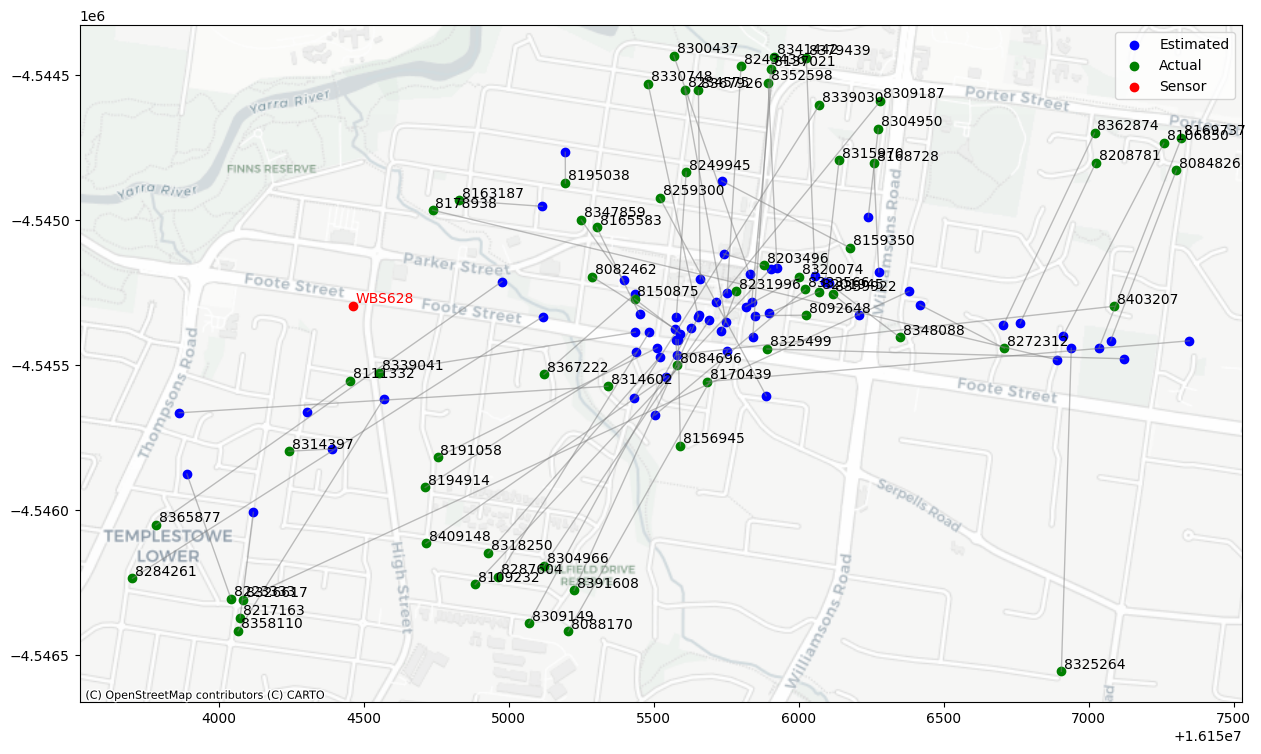

In [ ]:
# Actual vs. Mean of Estimate Lekage Points Plot
plot_estimate_point_names(sensor_coords, results_mean_df)

In [ ]:
import numpy as np
from geopy.distance import geodesic

# Function to calculate Haversine distance
def haversine_distance(lat1, lon1, lat2, lon2):
    point1 = (lat1, lon1)
    point2 = (lat2, lon2)
    return geodesic(point1, point2).kilometers  # Return the distance in kilometers

# Function to calculate Euclidean distance
def euclidean_distance(lat1, lon1, lat2, lon2):
    return np.sqrt((lat2 - lat1)**2 + (lon2 - lon1)**2)

# Create a new dataframe with the relevant distances
def calculate_distances(results_mean_df):
    # Calculate the Euclidean and Haversine distances for each row
    results_mean_df['Euclidean_Distance'] = results_mean_df.apply(
        lambda row: euclidean_distance(row['Actual_Latitude'], row['Actual_Longitude'],
                                       row['Estimated_Latitude'], row['Estimated_Longitude']), axis=1)

    results_mean_df['Haversine_Distance'] = results_mean_df.apply(
        lambda row: haversine_distance(row['Actual_Latitude'], row['Actual_Longitude'],
                                       row['Estimated_Latitude'], row['Estimated_Longitude']), axis=1)

    # Sort by the Euclidean distance in ascending order
    results_mean_df_sorted = results_mean_df.sort_values(by='Euclidean_Distance').reset_index(drop=True)

    return results_mean_df_sorted[['Job_ID','Actual_Latitude','Actual_Longitude','Estimated_Latitude','Estimated_Longitude', 'Priority', 'Euclidean_Distance', 'Haversine_Distance']]

# Example usage with results_mean_df
sorted_distances_df = calculate_distances(results_mean_df)

# Print the sorted table
print(sorted_distances_df.head())


    Job_ID  Actual_Latitude  Actual_Longitude  Estimated_Latitude  \
0  8084696       -37.759454        145.128055          -37.758825   
1  8195038       -37.754992        145.124592          -37.754239   
2  8359922       -37.757701        145.132867          -37.758229   
3  8231996       -37.757644        145.129883          -37.758627   
4  8203496       -37.757009        145.130750          -37.756727   

   Estimated_Longitude  Priority  Euclidean_Distance  Haversine_Distance  
0           145.128016       3.0            0.000630            0.069836  
1           145.124588       3.0            0.000753            0.083586  
2           145.133691       2.0            0.000979            0.093347  
3           145.129420       3.0            0.001086            0.116457  
4           145.129492       3.0            0.001289            0.115185  


In [ ]:
import matplotlib.pyplot as plt
import contextily as cx
import geopandas as gpd
import pandas as pd

def plot_jobs_on_map(sensor_coords, sorted_distances_df):
    # Set the number of jobs per chart
    jobs_per_chart = 30

    # Calculate the number of charts needed
    num_charts = len(sorted_distances_df) // jobs_per_chart + (len(sorted_distances_df) % jobs_per_chart > 0)

    for i in range(num_charts):
        # Get the subset of data for the current chart
        start_idx = i * jobs_per_chart
        end_idx = start_idx + jobs_per_chart
        subset_df = sorted_distances_df.iloc[start_idx:end_idx]

        # Convert the subset DataFrame to a GeoDataFrame for both estimated and actual points
        results_est_gdf = gpd.GeoDataFrame(subset_df, geometry=gpd.points_from_xy(subset_df['Estimated_Longitude'], subset_df['Estimated_Latitude']), crs='EPSG:4326').to_crs('EPSG:3857')
        results_act_gdf = gpd.GeoDataFrame(subset_df, geometry=gpd.points_from_xy(subset_df['Actual_Longitude'], subset_df['Actual_Latitude']), crs='EPSG:4326').to_crs('EPSG:3857')

        # Convert the sensor_coords to a DataFrame and GeoDataFrame
        sensor_df = pd.DataFrame.from_dict(sensor_coords, orient='index', columns=['Latitude', 'Longitude'])
        sensor_gdf = gpd.GeoDataFrame(sensor_df, geometry=gpd.points_from_xy(sensor_df['Longitude'], sensor_df['Latitude']), crs='EPSG:4326').to_crs('EPSG:3857')

        # Plot the estimated and actual points
        fig, ax = plt.subplots(figsize=(15, 10))
        results_est_gdf.plot(ax=ax, color="blue", label='Estimated')
        results_act_gdf.plot(ax=ax, color="green", label='Actual')
        sensor_gdf.plot(ax=ax, color="red", label='Sensor')

        # Add lines between actual and estimated points
        for j, row in subset_df.iterrows():
            ax.plot([results_act_gdf.geometry.x[j], results_est_gdf.geometry.x[j]],
                    [results_act_gdf.geometry.y[j], results_est_gdf.geometry.y[j]],
                    color='grey', linewidth=1, alpha=0.5)

            # Add the job_id next to the actual points
            job_id = int(row['Job_ID'])  # Convert job_id to integer
            ax.text(results_act_gdf.geometry.x[j] + 10, results_act_gdf.geometry.y[j] + 10,
                    str(job_id), fontsize=10, color='black')

        # Add the sensor names near the sensor points
        for sensor_name, row in sensor_gdf.iterrows():
            ax.text(row.geometry.x + 10, row.geometry.y + 10, sensor_name, fontsize=10, color='red')

        # Add basemap using Contextily
        cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

        # Set title for each chart
        ax.set_title(f'Job Distances (Chart {i + 1})')

        # Add a legend
        ax.legend()

        # Show the plot
        plt.tight_layout()
        plt.show()

# Example usage with sorted_distances_df
plot_jobs_on_map(sensor_coords, sorted_distances_df)


ModuleNotFoundError: No module named 'contextily'

In [ ]:
print(sorted_distances_df.head())

    Job_ID  Actual_Latitude  Actual_Longitude  Estimated_Latitude  \
0  8084696       -37.759454        145.128055          -37.758825   
1  8195038       -37.754992        145.124592          -37.754239   
2  8359922       -37.757701        145.132867          -37.758229   
3  8231996       -37.757644        145.129883          -37.758627   
4  8203496       -37.757009        145.130750          -37.756727   

   Estimated_Longitude  Priority  Euclidean_Distance  Haversine_Distance  
0           145.128016       3.0            0.000630            0.069836  
1           145.124588       3.0            0.000753            0.083586  
2           145.133691       2.0            0.000979            0.093347  
3           145.129420       3.0            0.001086            0.116457  
4           145.129492       3.0            0.001289            0.115185  


In [ ]:
sorted_distances_df.to_excel('/content/drive/My Drive/YVW/628.xlsx', index=False)

In [ ]:
from geopy.distance import geodesic

# Sensor coordinates (replace with your sensor data if there are more sensors)
sensor_latitude, sensor_longitude = sensor_coords['WBS628']

# Calculate the actual distance from the sensor to the actual leak coordinates using the Haversine formula
def haversine_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).kilometers

# Add actual sensor-leak distance to the dataframe
sorted_distances_df['Actual_Sensor_Distance'] = sorted_distances_df.apply(
    lambda row: haversine_distance(sensor_latitude, sensor_longitude,
                                   row['Actual_Latitude'], row['Actual_Longitude']),
    axis=1
)

# Add predicted sensor-leak distance to the dataframe
sorted_distances_df['Predicted_Sensor_Distance'] = sorted_distances_df.apply(
    lambda row: haversine_distance(sensor_latitude, sensor_longitude,
                                   row['Estimated_Latitude'], row['Estimated_Longitude']),
    axis=1
)


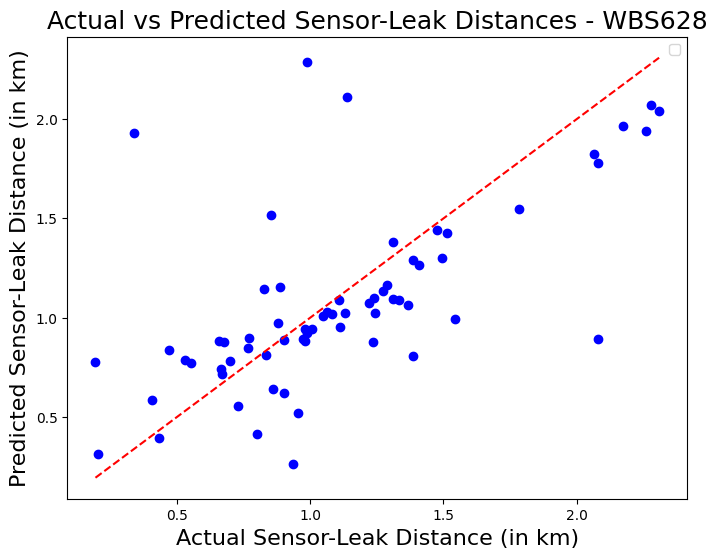

In [ ]:
# Scatter plot of actual vs predicted sensor-leak distances
plt.figure(figsize=(8, 6))

# Create scatter plot
plt.scatter(sorted_distances_df['Actual_Sensor_Distance'], sorted_distances_df['Predicted_Sensor_Distance'],
            color='blue', marker='o')

# Add a reference line where x = y to visualize perfect prediction
plt.plot([sorted_distances_df['Actual_Sensor_Distance'].min(), sorted_distances_df['Actual_Sensor_Distance'].max()],
         [sorted_distances_df['Actual_Sensor_Distance'].min(), sorted_distances_df['Actual_Sensor_Distance'].max()],
         color='red', linestyle='--')

# Add labels and title
plt.xlabel('Actual Sensor-Leak Distance (in km)', fontsize=16)
plt.ylabel('Predicted Sensor-Leak Distance (in km)', fontsize=16)
plt.title('Actual vs Predicted Sensor-Leak Distances - WBS628', fontsize=18)

# Display legend
plt.legend()

# Display the plot
plt.show()
